# Benchmark 
---

This notebook compares the decoder performance between Viterbi Decoder and Neural Decoder [1] on Convolution Codes over AWGN Channel.

Reference:
* [1] Kim, Hyeji, et al. "Communication Algorithms via Deep Learning." ICLR (2018)

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import pickle
import numpy as np
import commpy as cp
import tensorflow as tf
import multiprocessing as mp
from commpy.channelcoding import Trellis

from deepcom.metrics import BER, BLER       # metrics to benchmark Neural Decoder Model
from deepcom.utils import corrupt_signal     # simulate a AWGN Channel
from deepcom.model import NRSCDecoder        # Neural Decoder Model
from deepcom.dataset import data_genenerator, create_dataset

# Define a test dataset

In [3]:
NUM_EXAMPLES = 5000
BATCH_SIZE = 500       # depends on size of GPU, should be a factor of number_testing_sequences
BLOCK_LEN = 100        # length of a message bits
CONSTRAINT_LEN = 3     # num of shifts in Conv. Encoder
TRACE_BACK_DEPTH = 15  # (?) a parameter Viterbi Encoder

#  Generator Matrix (octal representation)
G = np.array([[0o7, 0o5]]) 
M = np.array([CONSTRAINT_LEN - 1])
trellis = Trellis(M, G, feedback=0o7)

_, Y_test = create_dataset(
    NUM_EXAMPLES, 
    100, 
    trellis, 
    snr=0.2, seed=1111)

# Load pre-trained Neural Decoder

In [4]:
try:
    model_path = os.path.join('BiGRU.hdf5')
    print(model_path)
    model = tf.keras.models.load_model(model_path, custom_objects={'BER': BER, 'BLER': BLER})
    model.compile(optimizer='adam', loss='binary_crossentropy')
    print('Pre-trained model is loaded.')
except Exception as e:
    print(e)
    raise ValueError('Pre-trained model is not found.')

BiGRU.hdf5
Pre-trained model is loaded.


# Setup Viterbi/Neural Decoder Benchmarks

In [5]:
def benchmark_neural_decoder(noisy_inputs, labels):
    
    # Preproces input and label vectors
    Y = np.reshape(labels, (-1, BLOCK_LEN, 1))
    X = np.reshape(np.array(noisy_inputs)[:, :2*BLOCK_LEN], 
                   (-1, BLOCK_LEN, 2))
    
    # Set up data generator
    test_set = data_genenerator(X, Y, BATCH_SIZE, shuffle=False)
    
    # Make predictions on batch
    decoded_bits = model.predict(
        test_set.make_one_shot_iterator(), 
        steps=len(Y) // BATCH_SIZE).round().astype(int)
    
    original_bits = np.reshape(Y, (-1, BLOCK_LEN)).astype(int)
    decoded_bits =  np.reshape(decoded_bits, (-1, BLOCK_LEN))

    # Compute hamming distances
    num_bit_errors_per_message = [cp.utilities.hamming_dist(
        x.astype(int),
        y.astype(int)
    ) for (x, y) in zip(original_bits, decoded_bits)]
    return num_bit_errors_per_message

def benchmark_viterbi(message_bits, noisy_bits, sigma):

    # Viterbi Decoder on Conv. Code
    decoded_bits = cp.channelcoding.viterbi_decode(
        coded_bits=noisy_bits.astype(float), 
        trellis=trellis,
        tb_depth=TRACE_BACK_DEPTH,
        decoding_type='unquantized')
    
    # Compute hamming distance
    num_bit_errors_per_message = cp.utilities.hamming_dist(
        message_bits.astype(int),
        decoded_bits[:-int(M)])
    return num_bit_errors_per_message


def generate_noisy_input(message_bits, trellis, snr):
    """For every SNR_db, we generates new noisy signals
    for fair comparision."""
    
    # Encode message bit
    coded_bits = cp.channelcoding.conv_encode(message_bits, trellis)
    
    # Corrupt message on BAWGN Channel
    noisy = cp.channels.awgn(coded_bits, snr, rate=0.5)
    
    return noisy, message_bits

In [6]:
viterbiBERs, viterbiBLERs = [], []
neuralBERs, neuralBLERs = [], []

pool = mp.Pool(processes=mp.cpu_count())
labels = np.reshape(Y_test, (-1, BLOCK_LEN)).astype(int)
try: 
    SNRs  = np.linspace(-1.0, 8.0, 10)
    for snr in SNRs:
        snr_linear = snr + 10 * np.log10(1./2.)
        sigma = np.sqrt(1. / (2. * 10 **(snr_linear / 10.)))
        print('[SNR]={:.2f}'.format(snr))
        
        # Generates new noisy signals
        result = pool.starmap(
            func=generate_noisy_input,  
            iterable=[(msg_bits, trellis, snr) for msg_bits in labels])
        X, Y =  zip(*result)
        
        # ###############################################
        # BENCHMARK NEURAL DECODER & VITERBI DECODER 
        # ###############################################
        t0 = time.time()
        
        neural_hamm_dists = benchmark_neural_decoder(X, Y)
        
        t1 = time.time()
        
        viterbi_hamm_dists = pool.starmap(
            func=benchmark_viterbi, 
            iterable=[(y, x, snr) for x, y in zip(X, Y)])
        
        t2 = time.time()
        
        # ################################################
        # Compute BER and BLER 
        # ################################################
        nn_ber = sum(neural_hamm_dists) / np.product(np.shape(Y))
        nn_bler = np.count_nonzero(neural_hamm_dists) / len(Y)
        
        vi_ber = sum(viterbi_hamm_dists) / np.product(np.shape(Y))
        vi_bler = np.count_nonzero(viterbi_hamm_dists) / len(Y)
        
        neuralBERs.append(nn_ber)
        neuralBLERs.append(nn_bler)            
        viterbiBERs.append(vi_ber)
        viterbiBLERs.append(vi_bler)
        print('\tNeural Decoder:  [BER]={:5.10f} [BLER]={:5.6f} -- {:3.3f}s'.format(
            nn_ber, nn_bler, t1 - t0)) 
        print('\tViterbi Decoder: [BER]={:5.10f} [BLER]={:5.6f} -- {:3.3f}s'.format(
              vi_ber, vi_bler,t2 - t1))
except Exception as e:
    print(e)
finally:
    pool.close()


[SNR]=-1.00
	Neural Decoder:  [BER]=0.1345480000 [BLER]=0.996600 -- 5.820s
	Viterbi Decoder: [BER]=0.1394220000 [BLER]=0.990600 -- 20.760s
[SNR]=0.00
	Neural Decoder:  [BER]=0.0859120000 [BLER]=0.957200 -- 3.655s
	Viterbi Decoder: [BER]=0.0883200000 [BLER]=0.940000 -- 20.780s
[SNR]=1.00
	Neural Decoder:  [BER]=0.0454400000 [BLER]=0.836600 -- 3.609s
	Viterbi Decoder: [BER]=0.0458920000 [BLER]=0.767400 -- 20.650s
[SNR]=2.00
	Neural Decoder:  [BER]=0.0197840000 [BLER]=0.555400 -- 3.610s
	Viterbi Decoder: [BER]=0.0194920000 [BLER]=0.469200 -- 20.755s
[SNR]=3.00
	Neural Decoder:  [BER]=0.0062820000 [BLER]=0.258200 -- 3.652s
	Viterbi Decoder: [BER]=0.0058420000 [BLER]=0.189800 -- 20.762s
[SNR]=4.00
	Neural Decoder:  [BER]=0.0016140000 [BLER]=0.083000 -- 3.686s
	Viterbi Decoder: [BER]=0.0015440000 [BLER]=0.060200 -- 20.794s
[SNR]=5.00
	Neural Decoder:  [BER]=0.0004060000 [BLER]=0.025200 -- 3.730s
	Viterbi Decoder: [BER]=0.0004000000 [BLER]=0.020800 -- 20.928s
[SNR]=6.00
	Neural Decoder:  [BER

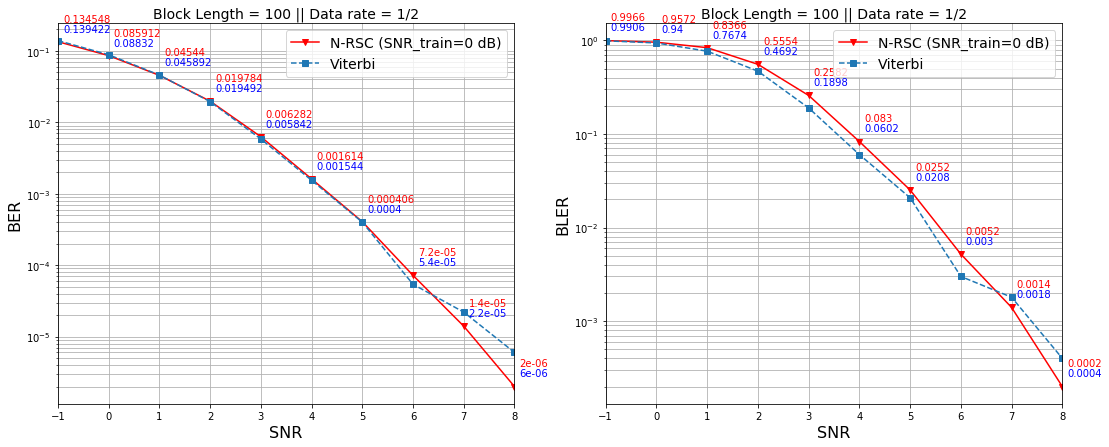

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# ###################################
# Plot Bit Error Rate (BER) Curve
# ###################################
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(SNRs, neuralBERs, '-vr')
plt.semilogy(SNRs, viterbiBERs, 's--')
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=14)
plt.xlabel('SNR', fontsize=16)
plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.ylabel('BER', fontsize=16)
plt.grid(True, which='both')

for (x, y1, y2) in zip(SNRs, neuralBERs, viterbiBERs):
    plt.annotate(str(y1), xy=(x,y1), xytext=(5,20), textcoords='offset points', color='red')
    plt.annotate(str(y2), xy=(x,y1), xytext=(5,10), textcoords='offset points', color='blue')

plt.savefig('result_ber_block_length_1000_snr0.png')
# ###################################
# Plot Block Error Rate (BLER) Curve
# ###################################
plt.subplot(1, 2, 2)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(SNRs, neuralBLERs, '-vr')
plt.semilogy(SNRs, viterbiBLERs, 's--')
plt.ylabel('BLER', fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=14)

plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.grid(True, which='both')
for (x, y1, y2) in zip(SNRs, neuralBLERs, viterbiBLERs):
    plt.annotate(str(y1), xy=(x,y1), xytext=(5,20), textcoords='offset points', color='red')
    plt.annotate(str(y2), xy=(x,y1), xytext=(5,10), textcoords='offset points', color='blue')

plt.savefig('result_bler_block_length_1000_snr0.png')